**INTRO TO XML**: https://www.w3schools.com/xml/xml_tree.asp

**--------------------------------- IMPORTING PACKAGES --------------------------------------**

In [1]:
import requests                               #makes data from URLs easy to gather
import xml.etree.ElementTree as ET            #stores hierarchical structures from XML
import csv
import pandas as pd
from IPython.display import display, HTML
import nltk                                   #natural language toolkit; helpful for string data
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
from wordcloud import WordCloud, STOPWORDS    #visualizing word in cloud
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm as cm               #correlation map
#from pydoc import help
from scipy.stats.stats import pearsonr        #pearson correlation
from scipy.stats import ttest_ind, ttest_rel
from collections import Counter
from scipy import stats

**--------------------------------- READING INTO XML FILE --------------------------------------**

**Converting XML to pandas dataframe to be able to manipulate data.**


In [2]:
#PARSING THROUGH XML FILE

"""


#no output achieved; parsing through file saved on machine
#code from Shreya

tree = ET.parse('../Desktop/Data/plant_catalog.xml')
root = tree.getroot()
#for child in root:
#    print child.tag, child.attrib, child.text

#print root.tag
#print root.attrib

dict_to_df = {}
for neighbor in root.findall('PLANT/PLANT'):
    print neighbor.tag, neighbor.attrib
    for child in neighbor:
       # print child.tag, child.attrib, child.text
        if (child.tag not in dict_to_df):
            dict_to_df[child.tag]=[child.text]
        else:
            dict_to_df[child.tag].append(child.text)
        print dict_to_df
for key, array in dict_to_df.items():
    print key,len(array)
    
"""

#obtained most code from http://www.austintaylor.io/lxml/python/pandas/xml/dataframe/2016/07/08/convert-xml-to-pandas-dataframe/
#https://www.w3schools.com/xml/xml_examples.asp

# another dataset: user_agent_url = 'https://www.w3schools.com/xml/simple.xml'
user_agent_url = 'https://www.w3schools.com/xml/plant_catalog.xml'
xml_data = requests.get(user_agent_url).content

class XML2DataFrame:

    def __init__(self, xml_data):                    #reading into file
        self.root = ET.XML(xml_data)

        
    
    def parse_root(self, root):                      #list of dictionaries and attributes of the children under this XML root.           
        return [self.parse_element(child) for child in iter(root)]

    
    def parse_element(self, element, parsed=None):   #Collect {key:attribute} and {tag:text} from XML elements and all children into a single dictionary of strings.
        if parsed is None:
            parsed = dict()
        for key in element.keys():
            parsed[key] = element.attrib.get(key)
        if element.text:
            parsed[element.tag] = element.text
        
        for child in list(element):                  #apply recursion
            self.parse_element(child, parsed)
        return parsed

    def process_data(self):                          #Initiate the root XML, parse it, and return a dataframe
        structure_data = self.parse_root(self.root)
        return pd.DataFrame(structure_data)

xml2df = XML2DataFrame(xml_data)
xml_df = xml2df.process_data()
del xml_df['PLANT']                                  #removed "PLANT" column since just a divider
display(HTML(xml_df.to_html()))



,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE
0,031599,Sanguinaria canadensis,Bloodroot,Mostly Shady,$2.44,4
1,030699,Aquilegia canadensis,Columbine,Mostly Shady,$9.37,3
2,051799,Caltha palustris,Marsh Marigold,Mostly Sunny,$6.81,4
3,030699,Caltha palustris,Cowslip,Mostly Shady,$9.90,4
4,012099,Dicentra cucullaria,Dutchman's-Breeches,Mostly Shady,$6.44,3
5,041899,Asarum canadense,"Ginger, Wild",Mostly Shady,$9.03,3
6,012699,Hepatica americana,Hepatica,Mostly Shady,$4.45,4
7,010299,Hepatica americana,Liverleaf,Mostly Shady,$3.99,4
8,020199,Arisaema triphyllum,Jack-In-The-Pulpit,Mostly Shady,$3.23,4
9,060599,Podophyllum peltatum,Mayapple,Mostly Shady,$2.98,3


**--------------------------------- EXTRACTING BASIC DATA FROM XML FILE --------------------------------------**


In [3]:
xml_df.nunique()

AVAILABILITY    32
BOTANICAL       25
COMMON          36
LIGHT            6
PRICE           36
ZONE             8
dtype: int64

In [4]:
xml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
AVAILABILITY    36 non-null object
BOTANICAL       36 non-null object
COMMON          36 non-null object
LIGHT           36 non-null object
PRICE           36 non-null object
ZONE            36 non-null object
dtypes: object(6)
memory usage: 1.8+ KB


In [5]:
group = xml_df.groupby(["LIGHT"])
for key,item in group:
    display(HTML(group.get_group(key).to_html()))

,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE
0,031599,Sanguinaria canadensis,Bloodroot,Mostly Shady,$2.44,4
1,030699,Aquilegia canadensis,Columbine,Mostly Shady,$9.37,3
3,030699,Caltha palustris,Cowslip,Mostly Shady,$9.90,4
4,012099,Dicentra cucullaria,Dutchman's-Breeches,Mostly Shady,$6.44,3
5,041899,Asarum canadense,"Ginger, Wild",Mostly Shady,$9.03,3
6,012699,Hepatica americana,Hepatica,Mostly Shady,$4.45,4
7,010299,Hepatica americana,Liverleaf,Mostly Shady,$3.99,4
8,020199,Arisaema triphyllum,Jack-In-The-Pulpit,Mostly Shady,$3.23,4
9,060599,Podophyllum peltatum,Mayapple,Mostly Shady,$2.98,3
12,020199,Claytonia Virginica,Spring-Beauty,Mostly Shady,$6.59,7


,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE
2,051799,Caltha palustris,Marsh Marigold,Mostly Sunny,$6.81,4


,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE
15,020199,Erythronium americanum,"Violet, Dog-Tooth",Shade,$9.04,4
16,032499,Erythronium americanum,Trout Lily,Shade,$6.94,4
17,041399,Erythronium americanum,Adder's-Tongue,Shade,$9.58,4
20,050399,Monarda didyma,Bee Balm,Shade,$4.59,4
21,042799,Monarda didyma,Bergamot,Shade,$7.16,4
23,061099,Ranunculus,Buttercup,Shade,$2.57,4
24,040399,Ranunculus,Crowfoot,Shade,$9.34,4
26,052599,Potentilla,Cinquefoil,Shade,$7.06,Annual
30,022199,Polemonium caeruleum,Jacob's Ladder,Shade,$9.26,Annual
31,071499,Polemonium caeruleum,Greek Valerian,Shade,$4.36,Annual


,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE
32,032799,Eschscholzia californica,California Poppy,Sun,$7.89,Annual


,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE
10,012299,Phlox divaricata,"Phlox, Woodland",Sun or Shade,$2.80,3
11,021699,Phlox divaricata,"Phlox, Blue",Sun or Shade,$5.59,3
13,042999,Trillium grandiflorum,Trillium,Sun or Shade,$3.90,5
14,022199,Trillium grandiflorum,Wake Robin,Sun or Shade,$3.20,5
28,051899,Gentiana,Gentian,Sun or Shade,$7.81,4
29,050299,Gentiana,Blue Gentian,Sun or Shade,$8.56,4


,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE
22,061899,Rudbeckia hirta,Black-Eyed Susan,Sunny,$9.80,Annual
25,063099,Asclepias tuberosa,Butterfly Weed,Sunny,$2.78,Annual
27,013099,Oenothera,Primrose,Sunny,$6.56,3 - 5


In [6]:
#finds how many times a word is repeated in given column
xml_df.LIGHT.str.split(expand=True).stack().value_counts()

Shade     18
Mostly    14
Shady     13
Sun        7
or         6
Sunny      4
dtype: int64

**--------------------------------- DATA MANIPULATION --------------------------------------**

**Grouping, Tokenizing, Wordcloud, label encoding, binary, pearson correlation**

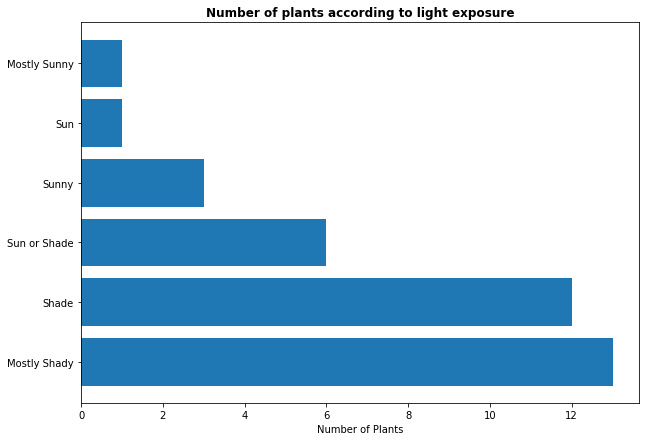

In [15]:
##import matplotlib.pyplot as plt; plt.rcdefaults()
#want to make more than one category

light = xml_df['LIGHT'].value_counts()
plt.figure(figsize=(10,7))

plt.barh(np.arange(len(light.index)), light.values)
plt.yticks(np.arange(len(light.index)), light.index)
plt.xlabel('Number of Plants')
plt.title('Number of plants according to light exposure', fontweight = 'bold')
plt.savefig('barh.png', bbox_inches="tight")
plt.show()

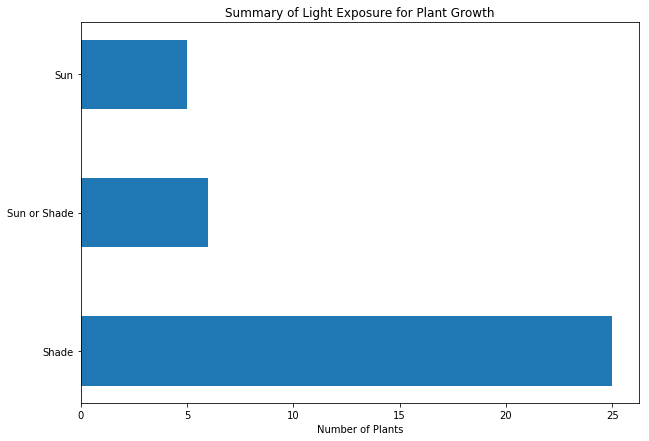

In [8]:
#combining categories

#initializing new categories
count_sun = (xml_df['LIGHT'] == 'Sunny').sum() + (xml_df['LIGHT'] == 'Mostly Sunny').sum() + (xml_df['LIGHT'] == 'Sun').sum()
count_SunOrShade = (xml_df['LIGHT'] == 'Sun or Shade').sum()
count_shade = (xml_df['LIGHT'] == 'Shade').sum() + (xml_df['LIGHT'] == 'Mostly Shady').sum()


categories = ['Shade', 'Sun or Shade', 'Sun']
y_pos = np.arange(len(categories))
height = [count_shade, count_SunOrShade, count_sun]

plt.figure(figsize=(10,7))
width = 0.5
plt.barh(y_pos, height, width)
plt.yticks(y_pos, categories)
plt.xlabel('Number of Plants')
plt.title('Summary of Light Exposure for Plant Growth')
plt.tight_layout
plt.show()              


In [9]:
#adds tokens to a list
tokens = xml_df['LIGHT']. apply(word_tokenize) 
#tokens_list = tokens.tolist()
#print tokens

flattened_list = []
for x in tokens:
    for y in x:
        flattened_list.append(y)

print flattened_list
print flattened_list.count('Sun')
print flattened_list.count('Shade')

['Mostly', 'Shady', 'Mostly', 'Shady', 'Mostly', 'Sunny', 'Mostly', 'Shady', 'Mostly', 'Shady', 'Mostly', 'Shady', 'Mostly', 'Shady', 'Mostly', 'Shady', 'Mostly', 'Shady', 'Mostly', 'Shady', 'Sun', 'or', 'Shade', 'Sun', 'or', 'Shade', 'Mostly', 'Shady', 'Sun', 'or', 'Shade', 'Sun', 'or', 'Shade', 'Shade', 'Shade', 'Shade', 'Mostly', 'Shady', 'Mostly', 'Shady', 'Shade', 'Shade', 'Sunny', 'Shade', 'Shade', 'Sunny', 'Shade', 'Sunny', 'Sun', 'or', 'Shade', 'Sun', 'or', 'Shade', 'Shade', 'Shade', 'Sun', 'Mostly', 'Shady', 'Shade', 'Shade']
7
18


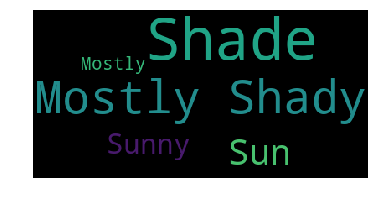

In [10]:
#WORDCLOUD - creating word cloud to visualize frequency of word used


wordcloud = WordCloud().generate(' '.join(xml_df['LIGHT']))
#wordcloud = WordCloud().generate(' '.join(xml_df['BOTANICAL']))

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png', bbox_inches="tight")
plt.show()

**--------------------------------- LABEL ENCODING & BINARY --------------------------------------**

reassigning column object to become category --> assign encoded value to different outputs in column

In [11]:
#fixing 'PRICE'
xml_df['PRICE'] = xml_df['PRICE'].str.replace('$', '')   #remove "$" from "PRICE" to make into integar
xml_df['PRICE'] = xml_df['PRICE'].astype(float)          #converts 'PRICE' from obj to float


#LABEL ENCODING
xml_df['LIGHT']= xml_df['LIGHT'].astype('category')      #convert 'LIGHT' from obj to category
xml_df["LIGHT_LE"] = xml_df["LIGHT"].cat.codes              #label encoding


xml_df['ZONE']= xml_df['ZONE'].astype('category')      #convert 'LIGHT' from obj to category
xml_df["ZONE_LE"] = xml_df["ZONE"].cat.codes              #label encoding


#BINARY- creates binary where one type is 1 and everything else in row is 0
#http://pbpython.com/categorical-encoding.html
xml_df["ZONE_binary"] = np.where(xml_df["ZONE"].str.contains("Annual"), 1, 0)



display(HTML(xml_df.to_html()))

,AVAILABILITY,BOTANICAL,COMMON,LIGHT,PRICE,ZONE,LIGHT_LE,ZONE_LE,ZONE_binary
0,031599,Sanguinaria canadensis,Bloodroot,Mostly Shady,2.44,4,0,3,0
1,030699,Aquilegia canadensis,Columbine,Mostly Shady,9.37,3,0,1,0
2,051799,Caltha palustris,Marsh Marigold,Mostly Sunny,6.81,4,1,3,0
3,030699,Caltha palustris,Cowslip,Mostly Shady,9.90,4,0,3,0
4,012099,Dicentra cucullaria,Dutchman's-Breeches,Mostly Shady,6.44,3,0,1,0
5,041899,Asarum canadense,"Ginger, Wild",Mostly Shady,9.03,3,0,1,0
6,012699,Hepatica americana,Hepatica,Mostly Shady,4.45,4,0,3,0
7,010299,Hepatica americana,Liverleaf,Mostly Shady,3.99,4,0,3,0
8,020199,Arisaema triphyllum,Jack-In-The-Pulpit,Mostly Shady,3.23,4,0,3,0
9,060599,Podophyllum peltatum,Mayapple,Mostly Shady,2.98,3,0,1,0


**--------------------------------- STATISTICAL TESTING --------------------------------------**


**There's always independent (eg gender) and dependent variable (eg test scores). If independent variable has more than one outcome, use ANOVA, otherwise use t-test. Testing done to determine to what degree of confidence the difference between means of 2 groups did not occur by chance.**

**T-TEST: used to determine if there's significant difference between the mean of 2 groups. infer that dependent variable fits normal distribution so we can always predict what the outcome is.** 
- **larger t score -> larger difference between both groups**
- **smaller p value -> less probability that results were by chance**

**ANOVA: similar to t-test but used if comparing means of more than 2 populations**


**PEARSON CORRELATION: gives strongest linear correlation between 2 groups, expressed in terms of r [-1,+1] where 0 means there's no correlation; can be either positively or negatively correlated**



In [12]:
#t-test
#2 independent samples
#returns (t-score, two-tailed p-value)


cat1 = xml_df['LIGHT_LE']
cat2 = xml_df['ZONE_LE']

ttest_ind(cat1, cat2)



#t-test
#2 dependent samples
#returns (t-score, two-tailed p-value)

#ttest_rel(cat3, cat4)

Ttest_indResult(statistic=-3.9756150768752128, pvalue=0.00016866606891517604)

In [13]:
#gives (Pearson's correlation coefficient, 2-tailed p-value)

#data = xml_df[['LIGHT','ZONE_binary']]

x = xml_df['ZONE_LE']
y = xml_df['PRICE']
pearsonr(x, y)
#correlation = data.corr(method='pearson')

(0.19293319874960782, 0.25958291200651146)

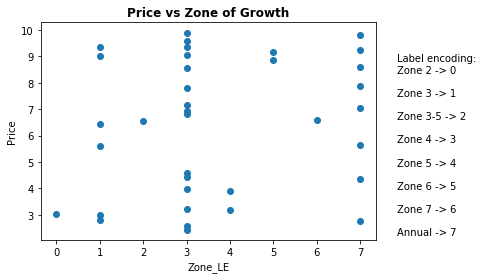

In [14]:
#import matplotlib

#matplotlib.style.use('ggplot')
x = xml_df['ZONE_LE']
y = xml_df['PRICE']
plt.scatter(x, y)
plt.xlabel('Zone_LE')
plt.ylabel('Price')
plt.title('Price vs Zone of Growth', fontweight = 'bold')
plt.figtext(.95, .1,'Label encoding: \nZone 2 -> 0\n \nZone 3 -> 1\n \nZone 3-5 -> 2\n \nZone 4 -> 3\n \nZone 5 -> 4\n \nZone 6 -> 5\n \nZone 7 -> 6\n \nAnnual -> 7\n')
plt.show()

**--------------------------------- TROUBLESHOOTING --------------------------------------**

- **Original dataset (https://data.cityofnewyork.us/api/views/kku6-nxdu.xml) had multiple tables so code used wasn't able to read through it.** 